In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import numpy as np
import math

In [2]:
def ReadImg(path: str):
    img = imread(path)
    if len(img.shape) == 3:
        img = img[:,:,0]
    return img.astype(float)

### Open image

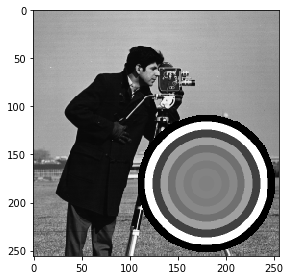

In [3]:
# Open grayscale image
image = ReadImg("test_images/example/in.bmp")
imshow(image.astype("uint8"), cmap='gray')

### Compute module of gradient

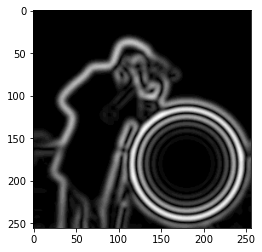

In [4]:
def Pad(img: np.array, size: int, kind='edge'):
    pad_size = ((size, size), (size, size))
    return np.pad(img, pad_size, kind)

def GetKernels(sigma: float):
    size = math.ceil(3 * sigma) * 2 + 1
    rad = size // 2
    x = np.arange(-rad, rad + 1, dtype=float)
    y = np.arange(-rad, rad + 1, dtype=float)[:,np.newaxis]
    exp = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    derive_x_gaussian = -1 / (2 * np.pi * sigma ** 4) * (x * exp)
    derive_y_gaussian = -1 / (2 * np.pi * sigma ** 4) * (y * exp)
    return derive_x_gaussian, derive_y_gaussian

def Normalization(image):
    return 255 * image / np.max(image)

def ComputeGrad(img, sigma):
    output = np.zeros_like(img)
    direction = np.zeros_like(img)
    kernel_x, kernel_y = GetKernels(sigma)
    rad = kernel_x.shape[0] // 2
    padded_img = Pad(img, rad)
    height, width = img.shape
    for y in range(height):
        for x in range(width):
            px = x + rad
            py = y + rad
            crop = padded_img[py-rad:py+rad+1, px-rad:px+rad+1]
            grad_x = int(np.sum(crop * kernel_x))
            grad_y = int(np.sum(crop * kernel_y))
            output[y, x] = np.sqrt(grad_x ** 2 + grad_y ** 2)
            direction[y, x] = np.arctan2(grad_y, grad_x) * (180.0 / np.pi)
    return Normalization(output), direction

plt.imshow(ComputeGrad(image, sigma=4)[0], cmap="gray")

### NMS

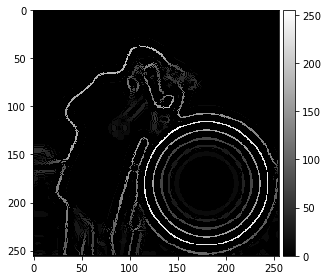

In [6]:
def GetBinGrad(value):
    if value < 0:
        value += 180
    anchor_val = np.array(range(0, 181, 45))
    return np.argmin(np.abs(anchor_val - value))

def GetMaxInDir(grad, pos, direction):
    x,y = pos
    if direction in [0, 4]:
        return max(grad[y][x - 1], grad[y][x + 1])
    elif direction == 2:
        return max(grad[y - 1][x], grad[y + 1][x])
    elif direction == 3:
        return max(grad[y - 1][x + 1], grad[y + 1][x - 1])
    else:
        return max(grad[y + 1][x + 1], grad[y - 1][x - 1])

def Nonmax(img, sigma):
    output = np.zeros(img.shape)
    grad, direction = ComputeGrad(img, sigma)
    height, width = grad.shape
    
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            dir_ = GetBinGrad(direction[y][x])
            pos = [x, y]
            if grad[y][x] >= GetMaxInDir(grad, pos, dir_):
                output[y][x] = grad[y][x]
    return output

imshow(Nonmax(image, sigma=4), cmap='gray')

### Double tresholding + Hysteresis

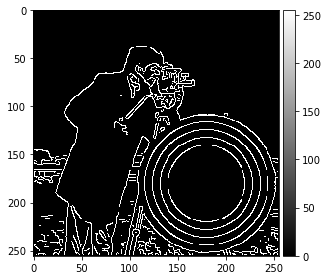

In [10]:
def GetMaxValInLocalArea(values, x, y):
    max_ = 0
    for dy in range(-1, 1):
        for dx in range(-1, 1):
            max_ = max(max_, values[y + dy][x + dx])
    return max_

def Canny(img, sigma, thr_high, thr_low):
    output = np.zeros(img.shape)
    # Get edges after nms
    edges = Nonmax(img, sigma)
    max_val = np.max(edges)
    height, width = edges.shape 
    
    # Strong values
    strong_val = 255
    for y in range(height):
        for x in range(width):
            if edges[y][x] >= thr_high * max_val:
                output[y][x] = strong_val
                
    # Weak values
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if output[y][x] == 0 and edges[y][x] >= thr_low * max_val:
                if GetMaxValInLocalArea(output, x, y) != 0:
                    output[y][x] = strong_val
    return output

imshow(Canny(image, 1, 0.1, 0.03), cmap='gray')          